In [147]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats("svg")

%matplotlib inline

### Controlled-Experiment using Pre-Experiment Data

In [134]:
def normal(mean: float, sd: float, size: int) -> np.array:
    return np.random.randn(size) * sd + mean


def ate(Y_A: np.array, Y_B: np.array) -> float:
    return Y_B.mean() - Y_A.mean()


def generate_experiment() -> pd.DataFrame:    
    n_samples = 1000
    
    sd = 5
    mean = 100
    effect = 2
    
    Y_A_pre = normal(mean, sd, n_samples)
    Y_B_pre = normal(mean, sd, n_samples)

    Y_A_post = Y_A_pre + 0 + normal(0, 2, n_samples)
    Y_B_post = Y_B_pre + effect + normal(0, 2, n_samples)
    
    Y_pre = np.concatenate([Y_A_pre, Y_B_pre])
    Y_post = np.concatenate([Y_A_post, Y_B_post])
    
    cov_matrix = np.cov(Y_pre, Y_post)
    theta = cov_matrix[0, 1] / cov_matrix[0, 0]
    
    Y_A_adj = Y_A_post - (Y_A_pre - Y_pre.mean()) * theta
    Y_B_adj = Y_B_post - (Y_B_pre - Y_pre.mean()) * theta

    return pd.DataFrame(
        {
            "Y_A_post": Y_A_post,
            "Y_B_post": Y_B_post,
            "Y_A_adj": Y_A_adj,
            "Y_B_adj": Y_B_adj,
        }
    )


def evaluate(exp: pd.DataFrame) -> dict:

    test = ttest_ind(exp["Y_A_post"], exp["Y_B_post"])
    test_adj = ttest_ind(exp["Y_A_adj"], exp["Y_B_adj"])

    return {
        "effect": ate(exp["Y_A_post"], exp["Y_B_post"]),
        "effect_adj": ate(exp["Y_A_adj"], exp["Y_B_adj"]),
        "stat": test.statistic,
        "stat_adj": test_adj.statistic,
        "pval": test.pvalue,
        "pval_adj": test_adj.pvalue,
    }

In [135]:
np.random.seed(0)
experiments = pd.DataFrame(evaluate(generate_experiment()) for _ in range(1000))

In [158]:
experiments.describe()

,effect,effect_adj,stat,stat_adj,pval,pval_adj
count,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1.000000e+03
mean,2.005252,1.998557,-8.333405,-22.362584,1.919109e-09,2.255989e-75
std,0.236180,0.088344,0.989225,1.050246,3.630413e-08,7.133961e-74
min,1.180798,1.718413,-11.861885,-26.340592,2.059561e-31,1.671825e-131
25%,1.854896,1.940064,-8.996329,-23.084122,5.288188e-19,1.038190e-104
50%,2.002009,1.997867,-8.308386,-22.352968,1.767721e-16,5.756030e-99
75%,2.163745,2.059455,-7.690873,-21.632170,2.278208e-14,2.060756e-93
max,2.822389,2.269974,-4.920953,-18.748329,9.317697e-07,2.255956e-72


In [136]:
experiment = generate_experiment()
experiment.std()

Y_A_post    5.208261
Y_B_post    5.350237
Y_A_adj     2.015308
Y_B_adj     2.015315
dtype: float64

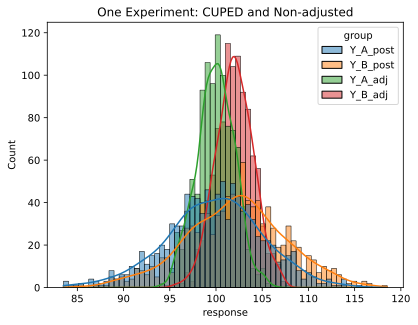

In [156]:
experiment_long = experiment.melt(
    value_vars=["Y_A_post", "Y_B_post", "Y_A_adj", "Y_B_adj"],
    var_name="group",
    value_name="response"
)

sns.histplot(experiment_long, x="response", hue="group", kde=True)
plt.title("One Experiment: CUPED and Non-adjusted")

plt.show()

In [161]:
experiments_long = (
    experiments[["effect", "effect_adj"]]
    .rename(columns={"effect": "non-adjusted", "effect_adj": "cuped"})
    .melt(
        value_vars=["non-adjusted", "cuped"],
        var_name="method",
        value_name="effect"
    )
)

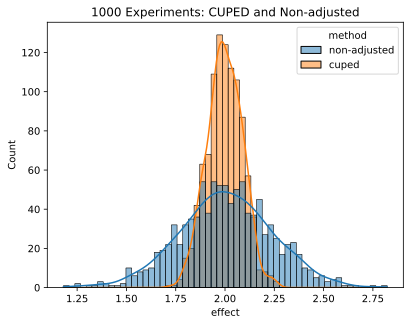

In [166]:
sns.histplot(experiments_long, x="effect", hue="method", kde=True)
plt.title("1000 Experiments: CUPED and Non-adjusted")
plt.show()